In [1]:
###### %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# convolutional autoencoder in keras

from __future__ import print_function

import tensorflow as tf

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Model
from keras.layers import *
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
# %matplotlib inline

from scipy.ndimage.filters import gaussian_laplace
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import nilearn
from nilearn import plotting

import brain_functions_final as bf

K.set_learning_phase(1)

/home/hoffmann/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### Create input

size=21

#train_path = "C:/Users/A2/Documents/CDS/MA/MA/test_pics/"
#test_path = "C:/Users/A2/Documents/CDS/MA/MA/test_pics/"

train_path = "/home/hoffmann/MRI/preprocessed/pre_train_data/"
test_path = "/home/hoffmann/MRI/preprocessed/pre_test_data/"

#bf.show_skull(test_path)

### Create Encoder

maxfil=512
bs_z=4
eps=2
    
name='512_maxfil_bsz_32_eps_100'
    
#test_batches, test_allpos=bf.loadbatches(test_path, size,False)
#autoencoder, encoder = bf.loadAutoencoder(name,size,maxfil)

#train_batches, train_allpos=bf.loadbatches(test_path, size)
#bf.pretrain(train_batches,name,size,maxfil,bs_z,eps)
#autoencoder, encoder = bf.unrollAndTrain(train_batches,name,size,maxfil,bs_z,eps)

#bf.pretrainPerPic(test_path, size, name, maxfil, eps)

#train_batches, train_allpos=bf.loadbatches(test_path, size, True)
#print(np.shape(train_batches))
#autoencoder, encoder = bf.unrollAndTrain(train_batches,name,size,maxfil,bs_z,eps)


In [ ]:
show_encode=False
show_filtered_encode=True
show_activation=False
show_filtered_activation=True

if show_encode:
    encoded_imgs = encoder.predict(test_batches)
    print(np.shape(test_batches))
    print(np.shape(encoded_imgs))

    bf.show_batch(test_batches, size, autoencoder.predict(test_batches))
    bf.show_encoded(test_batches, size, encoded_imgs, 1)

if show_activation:
    out, out_fil = bf.getMaxGrads(test_batches, name, size, maxfil, 't4c1')

    print(np.shape(out))
    print(np.shape(out_fil))

    bf.show_batch(test_batches, size, out)
    bf.show_batch(test_batches, size, out_fil)
    

show_recombine=False
    
if show_recombine:
    ### set patches back together

    control_batches, control_allpos, control_vip=bf.loadbatches(test_path, size, False)

    cpics = bf.recombine(control_batches, control_allpos)

    print(np.shape(cpics))
    bf.show_whole(cpics)

    comp=bf.load_whole(test_path)

    print(np.shape(comp))
    bf.show_whole(comp)

In [7]:
input_img = Input(shape=(size, size,size,1), dtype='float32')

train1_c1=Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='t1c1', activity_regularizer=bf.kl_reg)(input_img)
train1_decoded=Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same', name='t1tc1')(train1_c1)

train1_autoencoder = Model(input_img, train1_decoded)
train1_autoencoder.load_weights('weights/'+name+'_train1.h5', by_name=True)

train1_encoder=Model(input_img, train1_c1)

test_batches, test_allpos=bf.loadbatches(test_path, size,False)

train1_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21, 21, 21, 1)     0         
_________________________________________________________________
t1c1 (Conv3D)                (None, 21, 21, 21, 512)   14336     
_________________________________________________________________
t1tc1 (Conv3D)               (None, 21, 21, 21, 1)     13825     
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoded_imgs = train1_autoencoder.predict(test_batches)
encoded_imgs = train1_encoder.predict(test_batches[0:20])

(870, 21, 21, 21, 1)
(870, 21, 21, 21, 1)
(20, 21, 21, 21, 512)


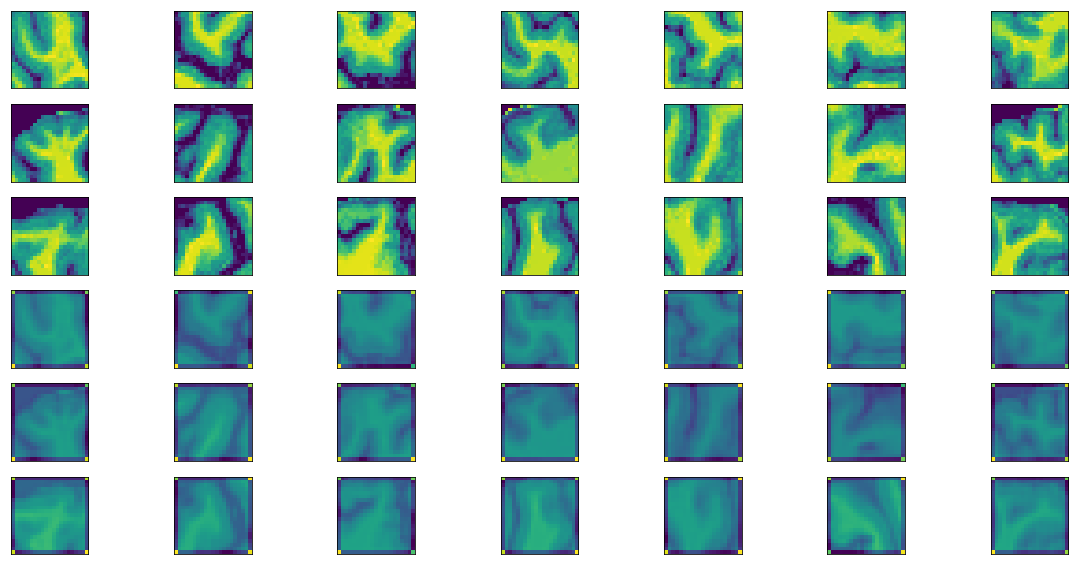

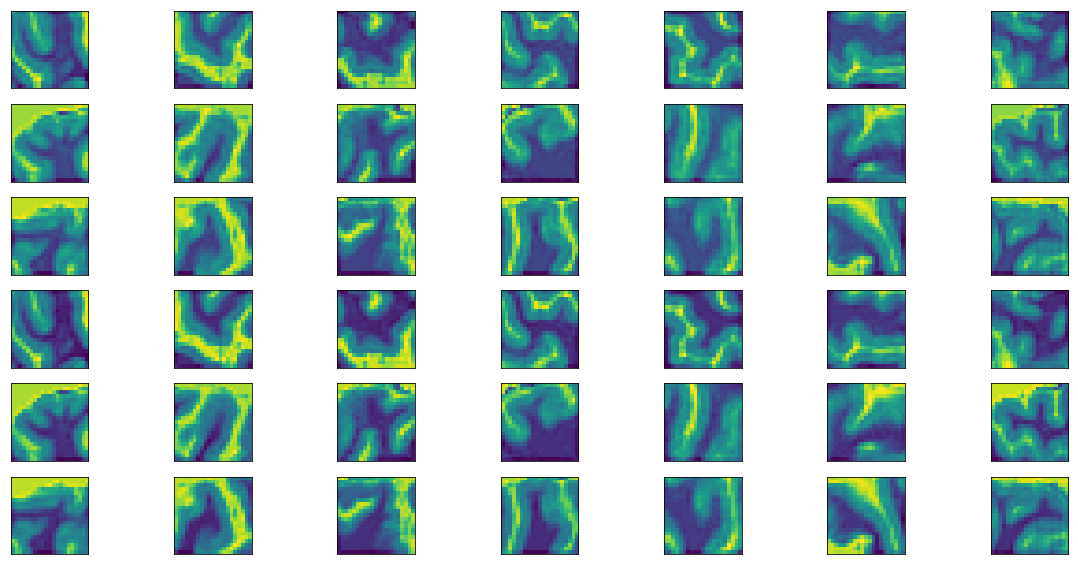

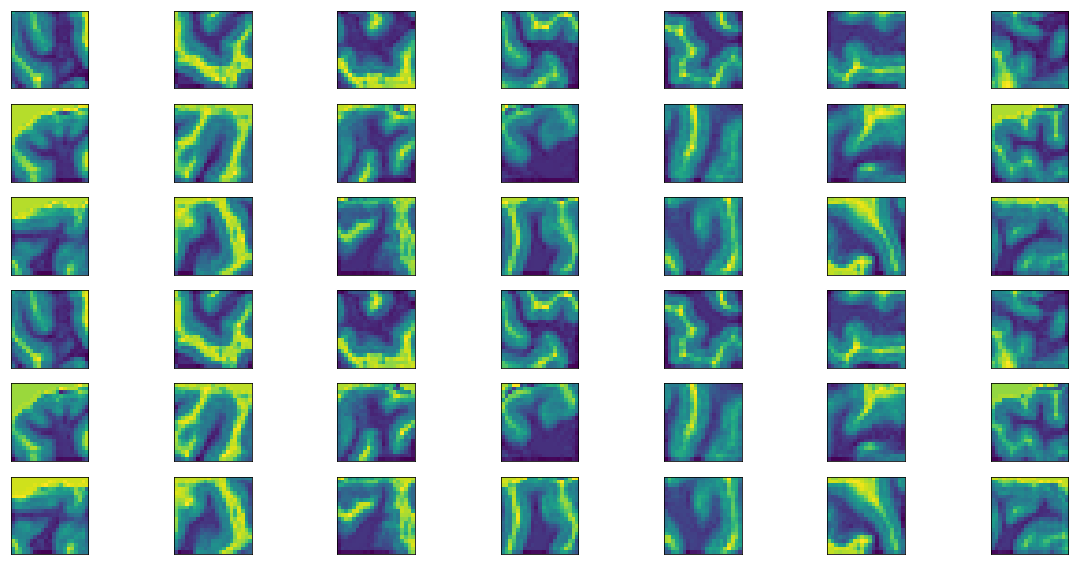

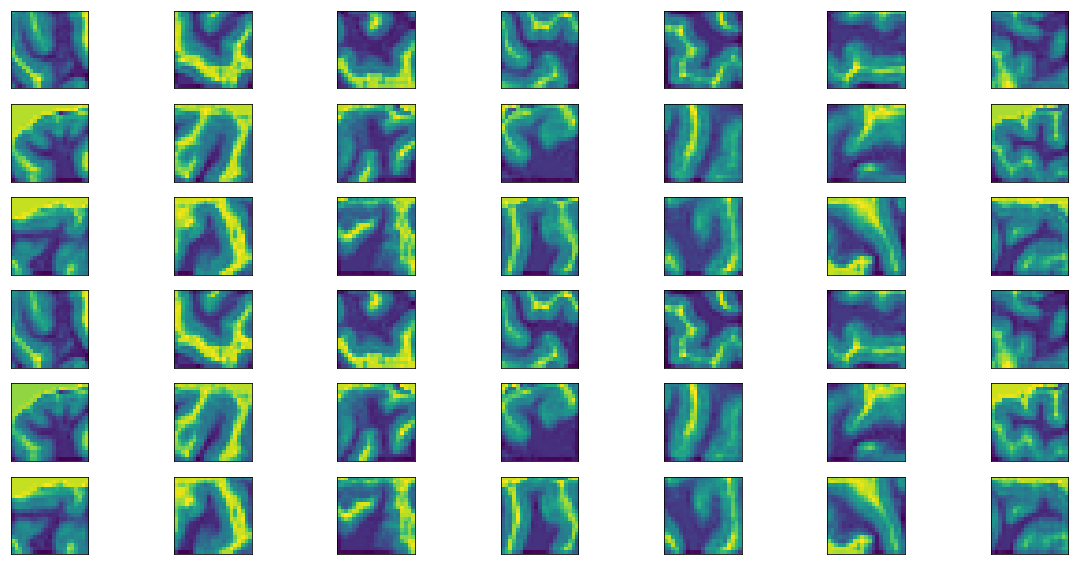

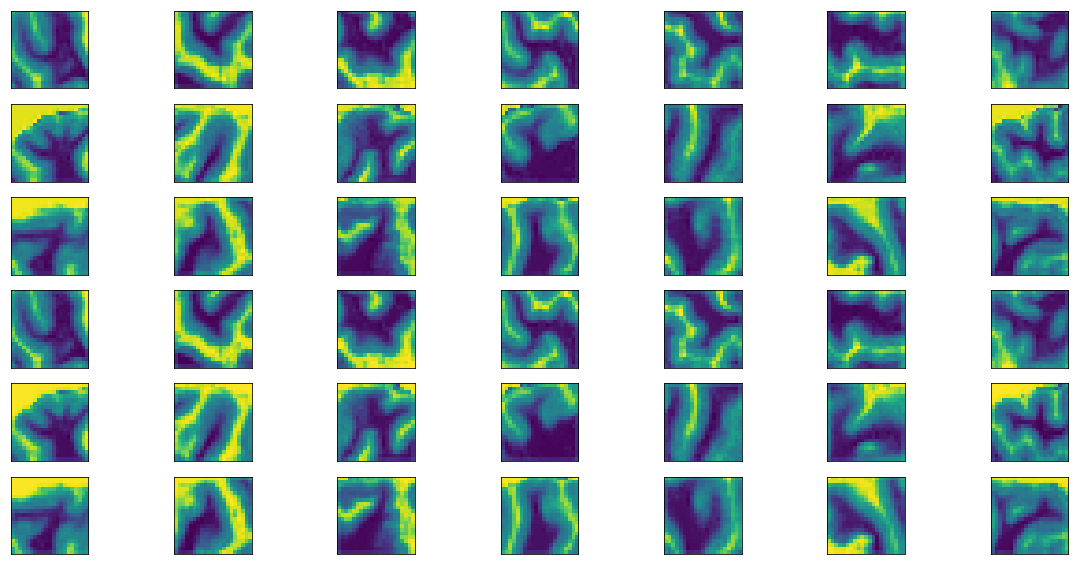

In [14]:
print(np.shape(test_batches))
print(np.shape(autoencoded_imgs))
print(np.shape(encoded_imgs))

bf.show_batch(test_batches, size, autoencoded_imgs)

bf.show_batch(encoded_imgs[:,:,:,:,0], size, encoded_imgs[:,:,:,:,1])
bf.show_batch(encoded_imgs[:,:,:,:,2], size, encoded_imgs[:,:,:,:,3])
bf.show_batch(encoded_imgs[:,:,:,:,4], size, encoded_imgs[:,:,:,:,5])
bf.show_batch(encoded_imgs[:,:,:,:,6], size, encoded_imgs[:,:,:,:,7])

In [18]:
input_set=test_batches[0:20]

layer_dict = dict([(layer.name, layer) for layer in train1_autoencoder.layers[1:]])

len1=len(input_set)
len2=len(input_set[0])
len3=len(input_set[0][0])
len4=len(input_set[0][0][0])

out = np.zeros((len1,len2,len3,len4))
out_fil = np.zeros((len1,len2,len3,len4))

nof=16

for i in range(nof):
    filter_index = i

    layer_output = layer_dict['t1c1'].output
    loss = K.mean(layer_output[:, :, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    #normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)  ### normalize? ... later

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    it = iterate([input_set])

    for j in range(len1):
        for k in range(len2):
            for l in range(len3):
                for m in range(len4):
                    if np.mean(abs(it[1][j][k][l][m])) > out[j][k][l][m]:   #abs()?
                        out[j][k][l]=abs(np.mean(it[1][j][k][l]))

    for j in range(len1):
        q = np.percentile(out[i],99)
        for k in range(len2):
            for l in range(len3):
                for m in range(len4):
                    if(out[j][k][l][m]>q):
                        out_fil[j][k][l][m]=out[j][k][l][m]

(20, 21, 21, 21)
(20, 21, 21, 21)


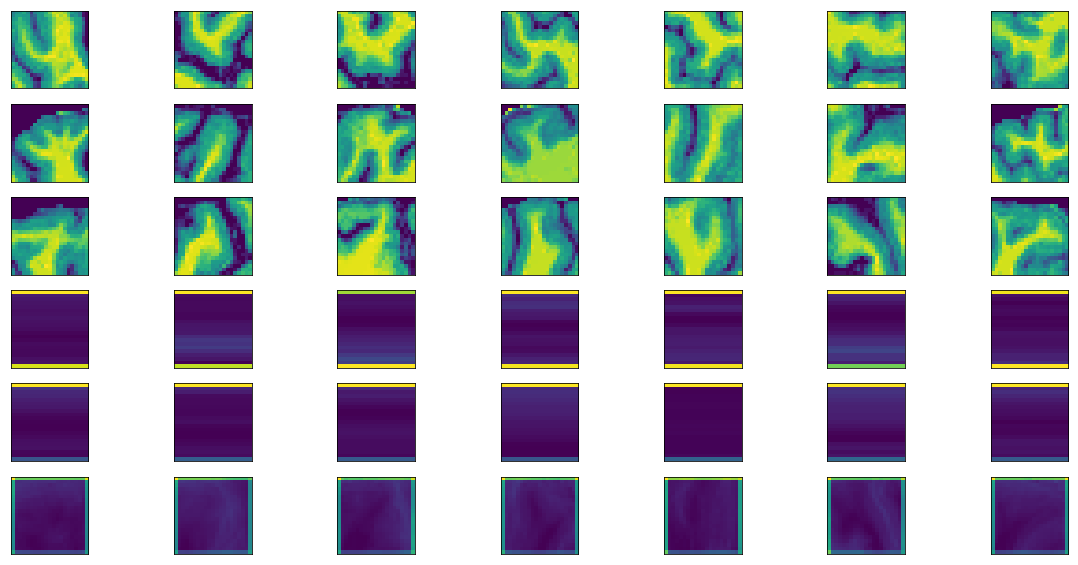

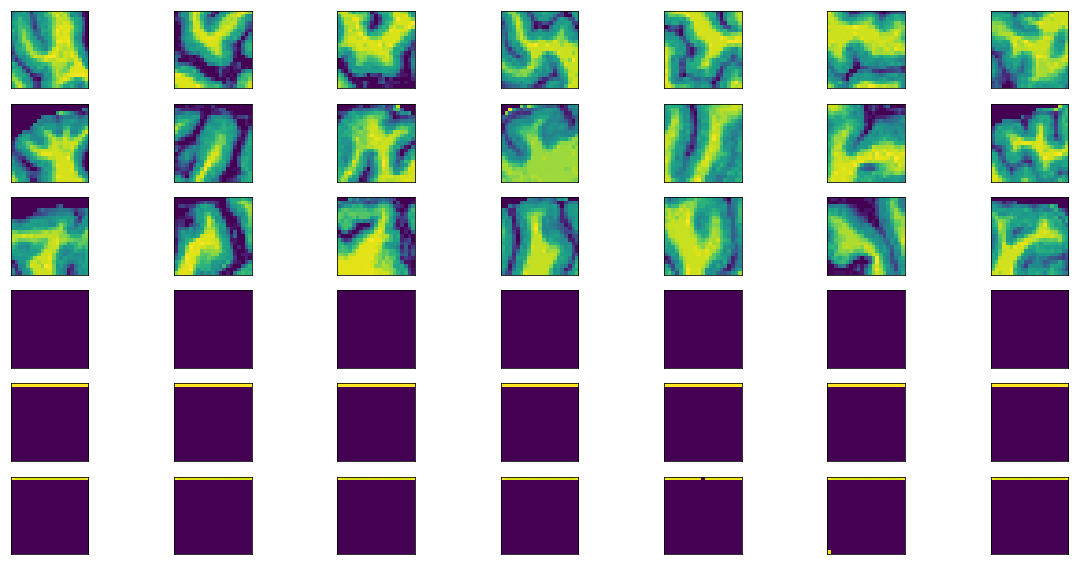

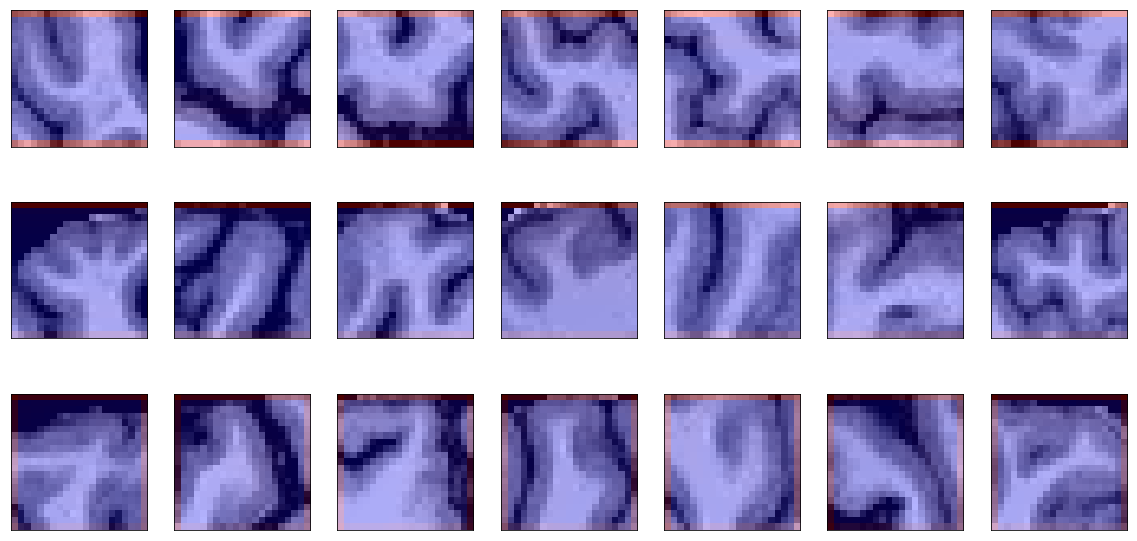

In [20]:
print(np.shape(out))
print(np.shape(out_fil))

bf.show_batch(test_batches, size, out)
bf.show_batch(test_batches, size, out_fil)

bf.show_heat_grads(test_batches, size, out, 7)

In [ ]:
cpics = bf.recombine(test_batches, test_allpos)
print(np.shape(cpics))
bf.show_whole(cpics)

ae_cpics = bf.recombine(autoencoded_imgs, test_allpos)
bf.show_whole(ae_cpics)

out_cpics = bf.recombine(out, test_allpos)
bf.show_whole(out_cpics)

outfil_cpics = bf.recombine(outfil, test_allpos)
bf.show_whole(outfil_cpics)

In [33]:
listing = os.listdir('/home/hoffmann/MRI/preprocessed/pre_train_data/')

print(listing[0:23])

print(len(listing))

['sub-032312_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032314_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032307_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032342_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032338_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032360_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032301_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032355_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032328_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032353_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032326_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032309_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032361_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032317_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032366_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032347_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032331_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032332_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032336_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032337_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032319_ses-01_acq-mp2rage_brain.nii.gz', 'sub-032350_ses-01_acq-mp2rage_br

In [ ]:
from keras.regularizers import Regularizer

def kl_divergence(p, p_hat):
    return (p * K.log(p / p_hat)) + ((1-p) * K.log((1-p) / (1-p_hat)))

class SparseActivityRegularizer(Regularizer):
    sparsityBeta = None

    def __init__(self, l1=0., l2=0., p=0.001, sparsityBeta=0.1):
        self.p = p
        self.sparsityBeta = sparsityBeta

    def set_layer(self, layer):
        self.layer = layer

    def __call__(self, loss):
        #p_hat needs to be the average activation of the units in the hidden layer.      
        p_hat = K.sum(K.mean(self.layer.get_output(True) , axis=0))

        loss += self.sparsityBeta * kl_divergence(self.p, p_hat)
        return loss

    def get_config(self):
        return {"name": self.__class__.__name__,"p": self.l1}

test_c1=Conv3D(maxfil, (3, 3, 3), activation='sigmoid', padding='same', name='t1c1', activity_regularizer=SparseActivityRegularizer(p=0.001, sparsityBeta=0.1))(input_img)
test_decoded=Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same', name='t1tc1', activity_regularizer=SparseActivityRegularizer(p=0.001, sparsityBeta=0.1))(test_c1)
    
test_autoencoder = Model(input_img, test_decoded)
test_autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

test_autoencoder.fit(train_batches, train_batches, 
                     validation_data=(test_batches, test_batches),
                     epochs=eps, batch_size=bs_z, verbose=1)
    
'''
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')

autoencoder = Sequential()
encoder = containers.Sequential([Dense(250, input_dim=576, init='glorot_uniform', activation='tanh', 
    activity_regularizer=SparseActivityRegularizer(p=-0.9, sparsityBeta=0.1))])

decoder = containers.Sequential([Dense(576, input_dim=250)])
autoencoder.add(AutoEncoder(encoder=encoder, decoder=decoder, output_reconstruction=True))
autoencoder.layers[0].build()
autoencoder.compile(loss='mse', optimizer=SGD(lr=0.001, momentum=0.9, nesterov=True))
loss = autoencoder.fit(X_train_tmp, X_train_tmp, nb_epoch=200, batch_size=800, verbose=True, show_accuracy=True, validation_split = 0.3)
autoencoder.save_weights('SparseAutoEncoder.h5',overwrite = True)
result = autoencoder.predict(X_test)
'''